In [22]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.signal import resample
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader


from transformers import WhisperTokenizer
from transformers import WhisperFeatureExtractor
from transformers import WhisperForConditionalGeneration

import evaluate
import re

def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove only ", ', and ,
    text = re.sub(r'[",\']', '', text)
    # Optional: remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


from jiwer import cer



def down_sample_audio(audio_original, original_sample_rate):
    target_sample_rate = 16000

    # Calculate the number of samples for the target sample rate
    num_samples = int(len(audio_original) * target_sample_rate / original_sample_rate)

    # Resample the audio array to the target sample rate
    downsampled_audio = resample(audio_original, num_samples)

    return downsampled_audio

In [2]:
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small",language='bengali',task='transcribe')
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small",language='bengali',task='transcribe')
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

In [3]:
# model.save_pretrained('runs/lora_adapter')

In [4]:
from datasets import load_dataset,concatenate_datasets

asr_dataset = load_dataset("Mohan-diffuser/odia-english-ASR")

Using the latest cached version of the dataset since Mohan-diffuser/odia-english-ASR couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/mohan.dash/.cache/huggingface/datasets/Mohan-diffuser___odia-english-asr/default/0.0.0/f509c51d69de15af3428978aa79b490863f32d2f (last modified on Wed Apr 30 12:44:57 2025).


In [5]:
asr_dataset['train'][0]


{'id': 62,
 'num_samples': 159360,
 'path': '/home/mohan.dash/.cache/huggingface/datasets/downloads/extracted/e2fcce8118681935ebfe4ee7e9b039155b764427d2269ffa5a66a0328fe9ec55/10020140876560357327.wav',
 'audio': {'path': '10020140876560357327.wav',
  'array': array([ 0.        ,  0.        ,  0.        , ..., -0.00582969,
         -0.00332552, -0.00426018]),
  'sampling_rate': 16000},
 'transcription': 'ତାଙ୍କର 2 ଘଣ୍ଟାର ଭାଷଣରେ ସେ କହିଥିଲେ ଯେ ଆଜି apple ତାର ଫୋନକୁ ପୁଣି ଉଦ୍ଭାବନ କରିବାକୁ ଯାଉଛି ଆମେ ଆଜି ଇତିହାସ ରଚିବାକୁ ଯାଉଛୁ',
 'raw_transcription': 'ତାଙ୍କର 2 ଘଣ୍ଟାର ଭାଷଣରେ ସେ କହିଥିଲେ ଯେ "ଆଜି Apple ତାର ଫୋନକୁ ପୁଣି ଉଦ୍ଭାବନ କରିବାକୁ ଯାଉଛି, ଆମେ ଆଜି ଇତିହାସ ରଚିବାକୁ ଯାଉଛୁ।"',
 'gender': 1,
 'lang_id': 72,
 'language': 'Oriya',
 'lang_group_id': 4,
 'eng_translation': 'In his 2-hour speech, he said that today Apple is going to reinvent its phone. We are going to make history today.'}

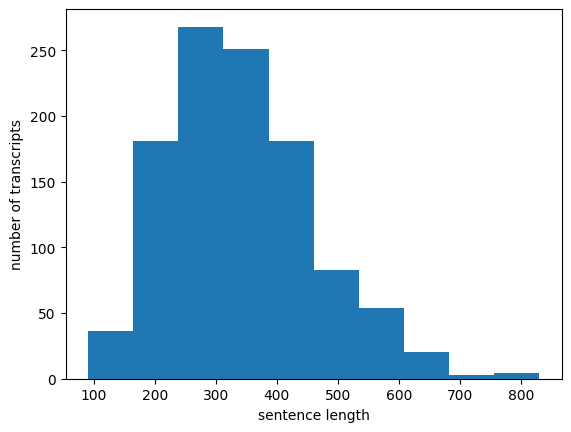

In [6]:
list_of_transcription_lengths = []

tokenized_text = tokenizer(asr_dataset['train']['transcription']).input_ids

for text in tokenized_text:
    list_of_transcription_lengths.append(len(text))
    # break

plt.hist(list_of_transcription_lengths)
plt.xlabel("sentence length")
plt.ylabel("number of transcripts")
plt.show()

In [7]:
import torch
model.eval()
model.config.use_cache=True

for idx in range(5):

    target = normalize_text(asr_dataset['train'][idx]['transcription'])
    audio_original = asr_dataset['train'][idx]['audio']['array']
    original_sample_rate = asr_dataset['train'][idx]['audio']['sampling_rate']

    audio_16000 = down_sample_audio(audio_original, original_sample_rate)

    input_feature = feature_extractor(raw_speech=audio_16000,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='bengali', task='transcribe')


    text_pred =  tokenizer.batch_decode(op,skip_special_tokens=True )[0]

    print(f'-------{idx}------')
    print(f'true : {target} \npred : {text_pred}')
    print('\n ')

You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


-------0------
true : ତାଙ୍କର 2 ଘଣ୍ଟାର ଭାଷଣରେ ସେ କହିଥିଲେ ଯେ ଆଜି apple ତାର ଫୋନକୁ ପୁଣି ଉଦ୍ଭାବନ କରିବାକୁ ଯାଉଛି ଆମେ ଆଜି ଇତିହାସ ରଚିବାକୁ ଯାଉଛୁ 
pred :  तांकर तुए गड़ार बासुनरे से कवितिले जे आप्प्रिल तार पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्पुन्प�

 
-------1------
true : ଖେଳଗୁଡିକ ସକାଳ 10:00 ରେ ଭଲ ପାଗ ସହିତ ଆରମ୍ଭ ହୋଇଥିଲା ଏବଂ ମଧ୍ୟରାତ୍ରିର ଝଡ଼ ବର୍ଷା ବ୍ୟତୀତ ଯାହା ଶୀଘ୍ର ସଫା ହୋଇଯାଇଥିଲା ଏହା 7 ମ ରଗବୀ ପାଇଁ ଏକ ଉପଯୁକ୍ତ ଦିନ ଥିଲା 
pred :  ḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍ

 
-------2------
true : ଯଦି ଜଣେ ଆରୋହୀଙ୍କୁ ଘୋଡ଼ାରୁ ଫୋପାଡି ଦିଆଯାଏ କିନ୍ତୁ ଗୋଡ଼ କୁଣ୍ଡାରେ ଅଟକିଯାଏ ତେବେ ଘୋଡ଼ା ଦୌଡ଼ି ପଳାଇଲେ ସେମାନେ ତା’ ସହ ଟାଣି ହୋଇଯାଆନ୍ତି। ଏହି ବିପଦକୁ ଏଡ଼ାଇବାକୁ ଅନେକ ସାବଧାନତା ଅବଲମ୍ବନ କରାଯାଇପାରେ। 
pred :  ज़दि

In [8]:

class whisper_training_dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len):#daatset is huggingface dataset object
        self.dataset = dataset
        self.max_len = max_len
        self.bos_token = model.config.decoder_start_token_id

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        audio_data = down_sample_audio(item['audio']["array"], item['audio']["sampling_rate"])
        input_features = feature_extractor(audio_data, sampling_rate=16000,return_tensors='pt').input_features[0]

        # Process the transcription
        transcription = item['transcription']

        # Create labels
        labels = tokenizer(transcription, padding="max_length", max_length=self.max_len, truncation=True, return_tensors="pt")
        labels = labels["input_ids"].masked_fill(labels['attention_mask'].ne(1), -100)
        labels = labels[0][1:]


        return {
            "input_features": input_features,
            "labels": labels
        }

In [20]:
dataset = whisper_training_dataset(dataset=asr_dataset['train'], max_len=400)

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,  # Adjust batch size as needed
    shuffle=True,  # Shuffle data during training
)

In [10]:

def evaluation(model):
    device = 'cuda'

    test_dataset = whisper_training_dataset(dataset=asr_dataset['validation'], max_len=60)

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=True,
    )

    model.eval()
    predictions = []
    references = []

    progress_bar = tqdm(test_dataloader, total=len(test_dataloader))

    for batch in progress_bar:
        model.eval()
        model.config.use_cache = True

        input_features = batch["input_features"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            generated_tokens = model.generate(input_features=input_features, language='bengali', task='transcribe')

        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

        # Update global lists
        predictions.extend(decoded_preds)
        references.extend(decoded_labels)

        # Compute batch WER (not cumulative)
        batch_cer = cer(decoded_labels, decoded_preds) * 100
        progress_bar.set_postfix(batch_CER=f"{batch_cer:.2f}%")

    total_cer = cer(references,predictions) * 100
    return total_cer

In [11]:
# WER before the training
torch.cuda.empty_cache()
evaluation(model)

100%|██████████| 49/49 [04:10<00:00,  5.11s/it, batch_CER=924.57%] 


853.3625197616441

In [12]:
from peft import LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model

config = LoraConfig(r=64, lora_alpha=64, target_modules=["q_proj", "v_proj", "q_proj", "out_proj"], lora_dropout=0.05, bias="none")

model = get_peft_model(model, config)
model.print_trainable_parameters()

# model.save_pretrained('lora_model')

# model = PeftModel.from_pretrained(model,model_id='lora_model')

# for n,p in model.named_parameters():
#     print(n,p.requires_grad)



trainable params: 10,616,832 || all params: 252,351,744 || trainable%: 4.2072


In [19]:

test_dataset = whisper_training_dataset(dataset=asr_dataset['validation'], max_len=400)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=8,  # Adjust batch size as needed
    shuffle=True,  # Shuffle data during training
)

In [23]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

torch.cuda.empty_cache()
model.config.use_cache = False
model.train()

device = 'cuda'
# Filter parameters with requires_grad=True
requires_grad_params = filter(lambda x: x[1].requires_grad, model.parameters())
optimizer = torch.optim.AdamW(requires_grad_params, lr=5e-4)  # Only for LoRA Training

max_epochs = 4
gradient_accumulation_steps = 4

running_train_loss = []
running_val_loss = []
running_cer = []

global_step = 0
accumulated_loss = 0

for epoch in range(max_epochs):
    for step, batch in enumerate(tqdm(train_dataloader, total=len(train_dataloader), leave=False)):

        model.config.use_cache = False
        model.train()
        input_features, labels = batch["input_features"].to(device), batch["labels"].to(device)

        outputs = model(input_features, labels=labels)
        loss = outputs.loss
        loss = loss / gradient_accumulation_steps  # Scale the loss

        loss.backward()
        accumulated_loss += loss.item()

        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            running_train_loss.append(accumulated_loss)
            accumulated_loss = 0
            global_step += 1

            # Validation loop
            if global_step % 50 == 0:
                model.eval()
                val_loss = 0.0
                with torch.no_grad():
                    for val_batch in test_dataloader:
                        val_input, val_labels = val_batch["input_features"].to(device), val_batch["labels"].to(device)
                        val_outputs = model(val_input, labels=val_labels)
                        val_loss += val_outputs.loss.item()
                val_loss /= len(test_dataloader)
                running_val_loss.append(val_loss)

                # Plot both train and val loss
                clear_output(wait=True)
                plt.plot(running_train_loss, label='Training Loss')
                plt.plot([i * 5 for i in range(len(running_val_loss))], running_val_loss, label='Validation Loss')
                plt.xlabel('Steps')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid()
                plt.title(f'Epoch {epoch+1}, Step {step+1}')
                plt.show()

            # Save model every 100 global steps
            if global_step % 100 == 0:
                model.save_pretrained('lora_model')

    torch.cuda.empty_cache()
    cer_value = evaluation(model)  # Assuming evaluation returns WER
    running_cer.append(cer_value)


  0%|          | 0/136 [00:00<?, ?it/s]

 14%|█▍        | 7/49 [00:42<04:13,  6.04s/it, batch_CER=515.95%]


KeyboardInterrupt: 

# Evaluate the model

In [5]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.signal import resample
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader


from transformers import WhisperTokenizer
from transformers import WhisperFeatureExtractor
from transformers import WhisperForConditionalGeneration

from peft import LoraConfig, get_peft_model, PeftModel

import evaluate
#pip install jiwer

wer  = evaluate.load('wer')



def down_sample_audio(audio_original, original_sample_rate):
    target_sample_rate = 16000

    # Calculate the number of samples for the target sample rate
    num_samples = int(len(audio_original) * target_sample_rate / original_sample_rate)

    # Resample the audio array to the target sample rate
    downsampled_audio = resample(audio_original, num_samples)

    return downsampled_audio

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small",language='bengali',task='translate')
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small",language='bengali',task='translate')
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

model = PeftModel.from_pretrained(model, 'lora_adapter', is_trainable=False)

model.eval()
model.to('cuda')


torch.cuda.empty_cache()


In [7]:
import torch
model.eval()
model.config.use_cache=True

for idx in range(5):

    target = asr_dataset['validation'][idx]['eng_translation']
    audio_original = asr_dataset['validation'][idx]['audio']['array']
    original_sample_rate = asr_dataset['validation'][idx]['audio']['sampling_rate']

    audio_16000 = down_sample_audio(audio_original, original_sample_rate)

    input_feature = feature_extractor(raw_speech=audio_16000,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='bengali', task='translate')


    text_pred =  tokenizer.batch_decode(op,skip_special_tokens=True )[0]

    print(f'-------{idx}------')
    print(f'true : {target} \npred : {text_pred}')
    print('\n ')

-------0------
true : Animals such as elephants and giraffes have a tendency to come up to take a closer look at cars and standard equipment that looks good. 
pred : Consultation is an excellent way to see the car and well seen by the hand-made animals of the pastures.

 
-------1------
true : Please treat this place with the honesty, seriousness, and respect it deserves. Don't make jokes about the Holocaust or the Nazis. 
pred : Sympathy in the place is hard to think of with deep feelings and thoughts about alcoholics or alcoholic topics.

 
-------2------
true : 108 types of Chhapan Bhog In Hinduism, 56 types of food items such as sweet fruits, almond dishes, etc. which are offered to God were offered to Baba Shyam. 
pred : The 18-day anniversary of the event was celebrated by the Hinduism and by the sweet fruit-ed-grain season as well as the season of the season of the season of the season of the season of the season of the season of the season of the season of the season of the sea